(knn_calibration)=
# KNN calibration

KNN filtering is a novel data-driven, likelihood-free calibration method based on a non-parametric kernel average smoother, whereby *posterior parameter samples* can be filtered using some certain norm $\| \cdot \|$ as the discrepancy measure $\delta$. Intuitively, it could be conceptually seen as a dictionary mapping between parameters and data. 

Given empirical observation, the most likely parameters, as if nearest neighbours parameterised by $K$ to the ground truth, are found through the defined norm. For this to work, it is typically needed for the parameter space to be explored first by, for instance, uniform sampling, followed by the KNN filtration process.

This notebook demonstrates its capability using a paraboloid model as the data generating mechanism.


```{note}
This is a likelihood-free approach, allowing calibration on epistemic parameters.
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyuncertainnumber.calibration.knn import KNNCalibrator, estimate_p_theta_knn
import pyuncertainnumber.calibration.knn
# from knn import KNNCalibrator   # import your calibrator (adjust path if needed) # from pyuncertainnumber.calibration.knn import KNNCalibrator
rng = np.random.default_rng(12)

plt.rcParams.update({
        "font.size": 11,
        "text.usetex": False,
        "font.family": "serif",
        "figure.figsize": (6, 4.5),
        "legend.fontsize": 'small',
        })

### Data generating mechanism

In [ ]:
def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5):
    """Vectorized paraboloid, mild noise; supports scalar or vector xi."""
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:
        xi = np.full(theta.shape[0], xi)
    elif xi.ndim == 2:
        xi = xi.ravel()
    y = A * x1**2 + B * x1 * x2 * (1.0 + xi) + C * (x2 + xi) ** 2
    y = y + 0.2 * np.random.randn(theta.shape[0])  # small noise
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])

def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))

def scatter_post(ax, theta, truth=None, title="", alpha=0.30, s=6, label="Posterior"):
    ax.scatter(theta[:,0], theta[:,1], s=s, alpha=alpha, label=label)
    if truth is not None:
        ax.scatter(truth[:,0], truth[:,1], c="r", marker="x", s=60, label="θ true cloud")
    ax.set_title(title); ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()


Generate empirical evidence (data from an unknown data generating process)

* Case 1 - 1 sample ($y$), 1 target ($\theta$ point-valued), 1 experiment ($\xi$)
* Case 2 - 100 sample ($y$) from 100 targets ($\theta$ distribution), 1 experiment ($\xi$)
* Case 3 - 100 sample ($y$) from 100 targets ($\theta$ distribution), for 4 experiments ($\xi$)


In [3]:
# generate data for the horse and pony show

# Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
theta_true_c1 = rng.normal(0, 4, size=(1, 2))   # unknown
xi_list_c1 = [0.0]  # selected (experiment)
y_emp = paraboloid_model(theta_true_c1, xi_list_c1)
observations_c1 = [(y_emp, xi_list_c1)]
print(f"CASE 1 - designs: {len(observations_c1)} samples: {observations_c1[0][0].shape[0]}")

# Case 2 - 100 sample (y) from 100 targets (θ distribution), 1 experiment (ξ)
N_emp = 100
xi_list_c2 = xi_list_c1
theta_true_cloud = rng.normal(4.0, 0.5, size=(N_emp, 2))   # unknown
y_emp= paraboloid_model(theta_true_cloud, xi_list_c1)
observations_c2 = [(y_emp, xi_list_c1)]

print(f"CASE 2 - designs: {len(observations_c2)} samples: {observations_c2[0][0].shape[0]}")

# Case 3 - 100 sample (y) from 100 targets (θ distribution), for 4 experiments (ξ)
xi_list_c3 = [-1.0, 0.0, 1.0, 3.0]
observations_c3 = []
for xi in xi_list_c3:
    y_emp  = paraboloid_model(theta_true_cloud, xi)  # shape (100,1) per design
    observations_c3.append((y_emp, xi))

print(f"CASE 3 - designs: {len(observations_c3)} samples: {observations_c3[0][0].shape[0]}")


CASE 1 - designs: 1 samples: 1
CASE 2 - designs: 1 samples: 100
CASE 3 - designs: 4 samples: 100


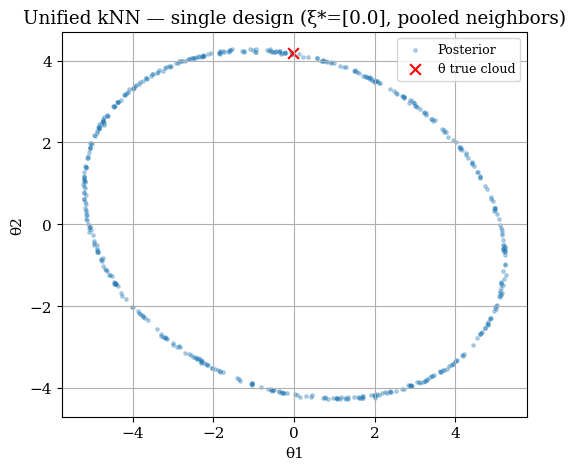

In [4]:
# set up knn calibrator
calib_single = KNNCalibrator(knn=500, evaluate_model=True)
calib_single.setup(model=paraboloid_model,
                   theta_sampler=theta_sampler,
                   xi_list=xi_list_c1, n_samples=500_000)
# run calibration
post_single = calib_single.calibrate(observations=observations_c1, combine="stack")  # pooled kNN
theta_post_single = post_single["theta"]

# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_single, truth=np.atleast_2d(theta_true_c1),
             title=f"Unified kNN — single design (ξ*={xi_list_c1}, pooled neighbors)")
plt.show()

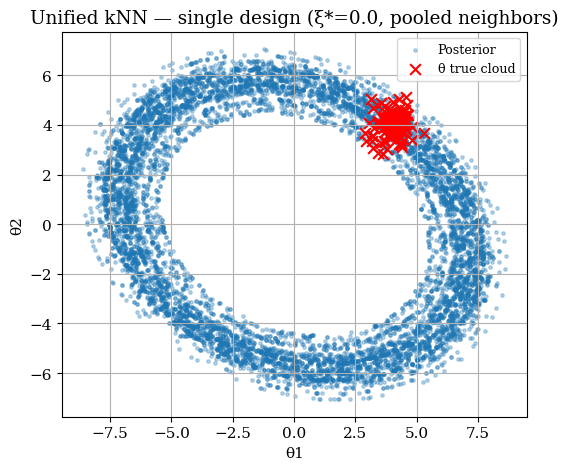

In [5]:
# set up knn calibrator
xi_star = 0.0
y_obs_star = next(y for (y, x) in observations_c2 if np.isclose(x, xi_star))

calib_single = KNNCalibrator(knn=100, evaluate_model=True)
calib_single.setup(model=paraboloid_model, theta_sampler=theta_sampler, xi_list=[xi_star], n_samples=100_000)
# run calibration
post_single = calib_single.calibrate([(y_obs_star, xi_star)], combine="stack")  # pooled kNN
theta_post_single = post_single["theta"]
# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_single, truth=theta_true_cloud,
             title=f"Unified kNN — single design (ξ*={xi_star}, pooled neighbors)")
plt.show()

```{tip}
Reuse precomputed simulations `(evaluate_model=False)`
```

### Build one big $(\theta, \xi)$ pool, then filter by $\xi^{*}$ to create per-design kNN indices

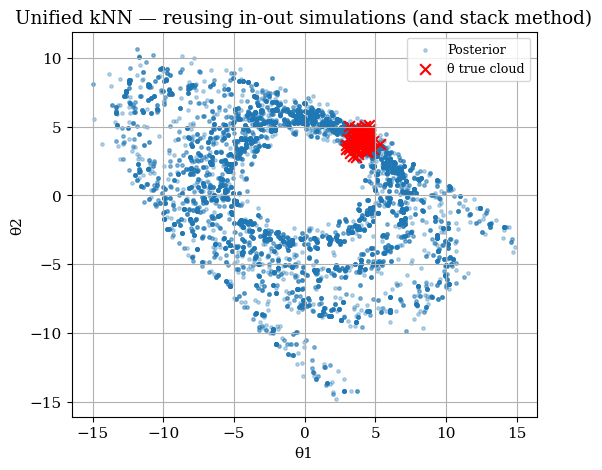

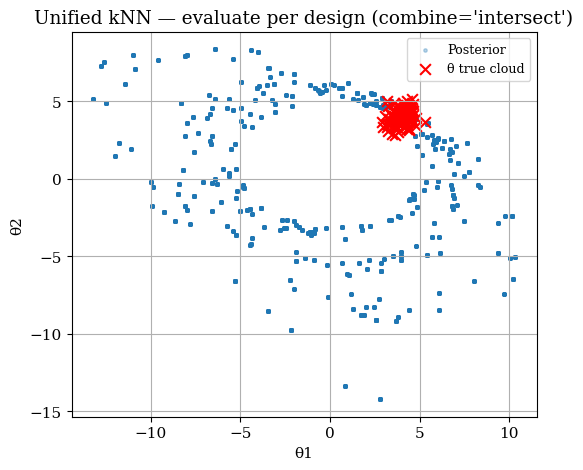

In [6]:

N_SIM = 1_000_000
knn = 10
resample_n = 10000

theta_sim_pool = theta_sampler(N_SIM)
xi_sim_pool = rng.uniform(-4, 4, size=(N_SIM, 1))
y_sim_pool = paraboloid_model(theta_sim_pool, xi_sim_pool)

simulated_data = {"y": y_sim_pool, "theta": theta_sim_pool, "xi": xi_sim_pool}
# 'prep model
calib_comb = KNNCalibrator(knn=knn, evaluate_model=False, a_tol=0.05)
calib_comb.setup(simulated_data=simulated_data, xi_list=xi_list_c3)


# 'vote' = stack
post_reuse = calib_comb.calibrate(observations_c3, combine="stack", resample_n=resample_n)
theta_post_reuse = post_reuse["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_reuse, truth=theta_true_cloud,
             title="Unified kNN — reusing in-out simulations (and stack method)")
plt.show()


# 'vote' = intersect
post_eval_vote = calib_comb.calibrate(observations_c3, combine="intersect", resample_n=resample_n)
theta_post_vote = post_eval_vote["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_vote, truth=theta_true_cloud,
             title="Unified kNN — evaluate per design (combine='intersect')")
plt.show()


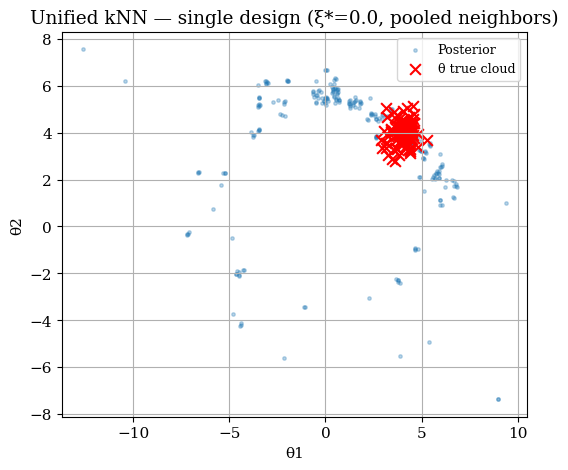

In [7]:

post = calib_comb.calibrate(
    observations_c3,
    combine="intersect",
    resample_n=None,          # <-- keep full weighted set
    combine_params={
                "theta_match_tol": 1e-3,
                "min_frac": 0.0,      # min occurrence fraction
                "gamma": 0.2,         # frequency sharpening
                "use_kde": True,      # enable KDE reweighting
                "kde_bw": 0.2
    }
)

theta_post = post["theta"]
w_post     = post.get("weights", None)   # now you have KDE weights too


# visualize
fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post[w_post>np.quantile(w_post,0.9),:], truth=theta_true_cloud,
             title=f"Unified kNN — single design (ξ*={xi_star}, pooled neighbors)")
plt.show()


### Per-design overlay

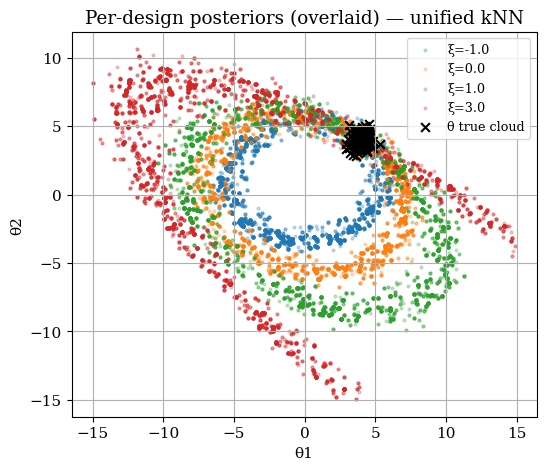

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for c, xi in zip(colors, xi_list_c3):
    post_xi = calib_comb.calibrate([(next(y for (y,x) in observations_c3 if np.isclose(x, xi)), xi)],
                                   combine="stack", resample_n=5000)
    th_xi = post_xi["theta"]
    ax.scatter(th_xi[:,0], th_xi[:,1], s=4, alpha=0.25, label=f"ξ={xi}", c=c)
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1], c="k", marker="x", s=40, label="θ true cloud")
ax.set_title("Per-design posteriors (overlaid) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()
plt.show()

In [9]:
from scipy.stats import gaussian_kde
posters = []
for xi in xi_list_c3:
    y_i = next(y for (y,x) in observations_c3 if np.isclose(x, xi))
    post_i = calib_comb.calibrate([(y_i, xi)], combine="stack", resample_n=1000)
    posters.append((xi, post_i["theta"]))

stack_all = np.vstack([th for _, th in posters] + [theta_true_cloud])
x_min, x_max = np.percentile(stack_all[:,0], [1, 99])
y_min, y_max = np.percentile(stack_all[:,1], [1, 99])
nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
grid = np.vstack([xx.ravel(), yy.ravel()])

zz = np.zeros((ny, nx))
for (c, (xi, th_xi)) in zip(colors, posters):
    kde = gaussian_kde(th_xi.T, bw_method='scott') # KDE on the posterior samples of this design
    zz_grid = kde(grid).reshape(ny, nx)
    zz += np.log(zz_grid)

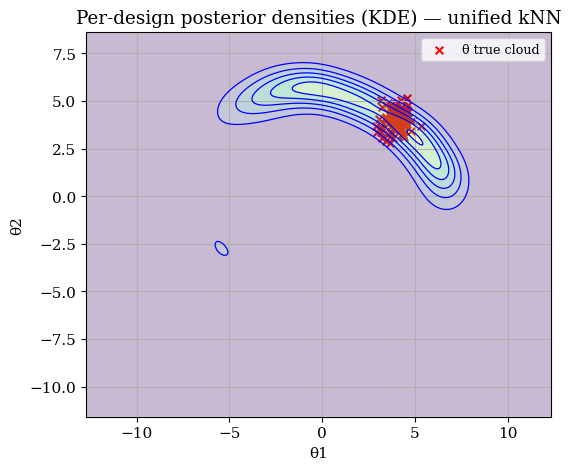

In [10]:

fig, ax = plt.subplots(figsize=(6,5))
# filled contours + a thin outline
zz_lik = np.exp(zz)

# true cloud on top
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1],
           c="r", marker="x", s=30, label="θ true cloud")

csf = ax.contourf(xx, yy, zz_lik, levels=8, alpha=0.3, antialiased=True)
ax.contour(xx, yy, zz_lik, levels=8, colors='b', linewidths=0.9)

ax.set_title("Per-design posterior densities (KDE) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.grid(True); ax.legend()
plt.show()
